<a href="https://www.kaggle.com/code/thiagosalesfreireluz/exoplanets-adaboost?scriptVersionId=224344701" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import time

#numpy.set_printoptions(threshold=sys.maxsize)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [2]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [3]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from numpy.random import seed
from sklearn.preprocessing import MinMaxScaler

In [4]:
data = pd.read_csv('../input/kepler-exoplanet-search-results/cumulative.csv')

In [5]:
#data

Feature selection

In [6]:
# getting data
df = data

# Drop unused columns
df = df.drop(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'koi_score'], axis=1)
  
# Limit target values to CANDIDATE and CONFIRMED
false_positive_rows = df.query("koi_disposition == 'FALSE POSITIVE'").index
df = df.drop(false_positive_rows, axis=0).reset_index(drop=True)

#Transforming target column in binary data
df['koi_disposition'] = df['koi_disposition'].map({"CANDIDATE":1,"CONFIRMED":0})
    
# Drop columns with all missing values
df = df.drop(['koi_teq_err1', 'koi_teq_err2'], axis=1)

# Fill remaining missing values
df['koi_tce_delivname'] = df['koi_tce_delivname'].fillna(df['koi_tce_delivname'].mode()[0])
for column in df.columns[df.isna().sum() > 0]:
    df[column] = df[column].fillna(df[column].mean())
    
# One-hot encode koi_tce_delivname column
delivname_dummies = pd.get_dummies(df['koi_tce_delivname'], prefix='delivname')
df = pd.concat([df, delivname_dummies], axis=1)
df = df.drop('koi_tce_delivname', axis=1)

# Split df into X and y
y = df['koi_disposition']
X = df.drop('koi_disposition', axis=1)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
# Scale X
"""scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)"""

# Scale min X to 0 and 1
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)



In [7]:
#df

In [8]:
#y_train

In [9]:
#Measure time
start_time = time.time()

In [10]:
#creating an Adaboost instance
clf = AdaBoostClassifier(n_estimators=974,learning_rate = 0.1)

#training the model
clf.fit(X_train, y_train)

print("trained")

trained


In [11]:
# def test_model(clf, X_train, y_train):
#     kf = KFold(n_splits=4)
#     mae_train = []
#     mae_test = []
#     for train_index, test_index in kf.split(X): 
#        clf.fit(X_train, y_train)
#        y_train_pred = clf.predict(X_train)
#        y_test_pred = clf.predict(X_test)
#        mae_train.append(mean_absolute_error(y_train, y_train_pred))
#        mae_test.append(mean_absolute_error(y_test, y_test_pred))
#     folds = range(1, kf.get_n_splits() + 1)
#     plt.plot(folds, mae_train, 'o-', color='green', label='train')
#     plt.plot(folds, mae_test, 'o-', color='red', label='test')
#     plt.legend()
#     plt.grid()
#     plt.xlabel('Number of fold')
#     plt.ylabel('Mean Absolute Error')
#     plt.show()

In [12]:
#test_model(clf,X_train,y_train)

In [13]:
def get_classifications(y_test, y_pred, positive_label=1):
    tp = 0
    fn = 0
    fp = 0
    tn = 0
    
    for y_t, y_p in zip(y_test, y_pred):
        if y_t == positive_label:
            if y_p == positive_label:
                tp += 1
            else:
                fn += 1
        else:
            if y_p == positive_label:
                fp += 1
            else:
                tn += 1
    
    return tp, fn, fp, tn

def get_accuracy(tp, fn, fp, tn):
    acc = (tp + tn) / (tp + fn + fp + tn)
    return acc

def get_precision(tp, fn, fp, tn):
    precision = tp / (tp + fp)
    return precision

def get_recall(tp, fn, fp, tn):
    recall = tp / (tp + fn)
    return recall

def get_f1_score(tp, fn, fp, tn):
    precision = get_precision(tp, fn, fp, tn)
    recall = get_recall(tp, fn, fp, tn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def get_sensitivity(tp, fn, fp, tn):
    sensitivity = tp / (tp + fn)
    return sensitivity

def get_specificity(tp, fn, fp, tn):
    specificity = tn / (tn + fp)
    return specificity

In [14]:
seed(0)

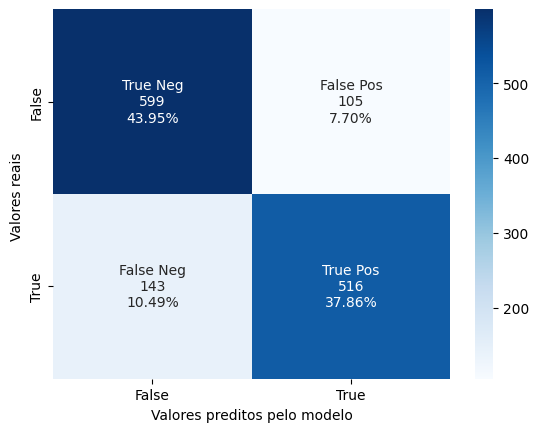

In [15]:
y_pred = clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('Valores preditos pelo modelo')
ax.set_ylabel('Valores reais ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.savefig('my_plot.TIFF')
plt.show()


In [16]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('Accuracy: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.81318681 0.85903084 0.80396476 0.85242291 0.81497797 0.78414097
 0.84361233 0.83039648 0.81497797 0.8215859  0.82857143 0.8215859
 0.81277533 0.83259912 0.8215859  0.81497797 0.83259912 0.83700441
 0.83920705 0.82378855 0.82637363 0.83480176 0.85022026 0.79735683
 0.81277533 0.80396476 0.82599119 0.83259912 0.8215859  0.83920705
 0.85274725 0.80837004 0.82378855 0.84140969 0.81057269 0.80176211
 0.80176211 0.84801762 0.84361233 0.79735683 0.82417582 0.81718062
 0.83700441 0.85462555 0.78634361 0.84140969 0.83920705 0.83700441
 0.81057269 0.83480176]
Accuracy: 0.8252 (0.0177)


In [17]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('sensitivity: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.72444444 0.84821429 0.76339286 0.83111111 0.78666667 0.74222222
 0.78222222 0.81333333 0.76444444 0.77777778 0.78222222 0.77678571
 0.75892857 0.81333333 0.8        0.76       0.77333333 0.8
 0.82222222 0.78666667 0.78666667 0.75892857 0.82142857 0.74666667
 0.76888889 0.73333333 0.76444444 0.81333333 0.77777778 0.84
 0.81777778 0.76339286 0.76785714 0.78222222 0.80444444 0.74222222
 0.76       0.80888889 0.82222222 0.75555556 0.76444444 0.75446429
 0.82589286 0.80888889 0.74222222 0.79555556 0.83111111 0.77333333
 0.77777778 0.80444444]
sensitivity: 0.7844 (0.0297)


In [18]:
specificity = make_scorer(recall_score, pos_label=0)

In [19]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, cv=cv, scoring = specificity, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('specificity: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.9        0.86956522 0.84347826 0.87336245 0.84279476 0.82532751
 0.90393013 0.84716157 0.86462882 0.86462882 0.87391304 0.86521739
 0.86521739 0.85152838 0.84279476 0.86899563 0.89082969 0.87336245
 0.8558952  0.86026201 0.86521739 0.90869565 0.87826087 0.84716157
 0.8558952  0.87336245 0.88646288 0.85152838 0.86462882 0.83842795
 0.88695652 0.85217391 0.87826087 0.89956332 0.81659389 0.86026201
 0.84279476 0.88646288 0.86462882 0.83842795 0.8826087  0.87826087
 0.84782609 0.89956332 0.82969432 0.88646288 0.84716157 0.89956332
 0.84279476 0.86462882]
specificity: 0.8651 (0.0214)


In [20]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='precision', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('precision: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.87634409 0.86363636 0.82608696 0.86574074 0.83098592 0.80676329
 0.88888889 0.83944954 0.84729064 0.84951456 0.85853659 0.84878049
 0.84577114 0.84331797 0.83333333 0.85074627 0.87437186 0.86124402
 0.84862385 0.84688995 0.85096154 0.89005236 0.86792453 0.82758621
 0.83980583 0.85051546 0.86868687 0.84331797 0.84951456 0.83628319
 0.87619048 0.83414634 0.86       0.88442211 0.81165919 0.83919598
 0.82608696 0.875      0.85648148 0.82125604 0.86432161 0.85786802
 0.84090909 0.88780488 0.81067961 0.87317073 0.84234234 0.88324873
 0.82938389 0.85377358]
precision: 0.8512 (0.0205)


In [21]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(clf, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
print(n_scores)
# report performance
print('f1 score: %.4f (%.4f)' % (mean(n_scores), std(n_scores)))

[0.79318735 0.85585586 0.79350348 0.84807256 0.80821918 0.77314815
 0.8321513  0.8261851  0.80373832 0.81206497 0.81860465 0.81118881
 0.8        0.8280543  0.81632653 0.8028169  0.82075472 0.82949309
 0.83521445 0.8156682  0.81755196 0.81927711 0.8440367  0.78504673
 0.80278422 0.7875895  0.81323877 0.8280543  0.81206497 0.83813747
 0.84597701 0.7972028  0.81132075 0.83018868 0.80803571 0.78773585
 0.79166667 0.84064665 0.83900227 0.78703704 0.81132075 0.80285036
 0.83333333 0.84651163 0.774942   0.83255814 0.83668904 0.82464455
 0.80275229 0.82837529]
f1 score: 0.8161 (0.0199)


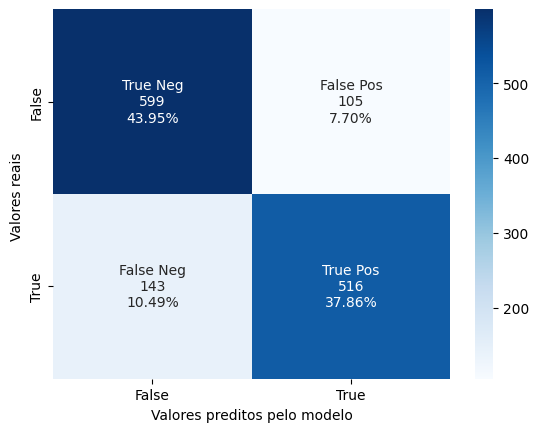

In [22]:
y_pred = clf.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

#ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('Valores preditos pelo modelo')
ax.set_ylabel('Valores reais ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.savefig('my_plot.TIFF')
plt.show()


In [23]:
# Print time
print("--- %s seconds ---" % (time.time() - start_time))

--- 1627.9223082065582 seconds ---


In [24]:
#model adaboost
#use adaboost API now
#adaboostTrain = clf.fit(X_train, y_train) 
#adaboostTest = clf.fit(X_test, y_test)

# Using GridSearchCV to tune the parameters of Adaboost

In [25]:
import numpy as np

In [26]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 40)]
print(n_estimators)
#learning_rate = [int(x) for x in np.linspace(start = 0.1, stop = 50, num = 10)]

[10, 35, 60, 86, 111, 136, 162, 187, 213, 238, 263, 289, 314, 340, 365, 390, 416, 441, 466, 492, 517, 543, 568, 593, 619, 644, 670, 695, 720, 746, 771, 796, 822, 847, 873, 898, 923, 949, 974, 1000]


In [27]:
# Exemplo dos parâmetros que quero testar.
parametros = {'n_estimators': n_estimators,
              'learning_rate': [0.1, 1, 2, 5, 10, 50, 100]}

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
# Criação do objeto do GridSearchCV.
# grid = GridSearchCV(estimator = clf,          # É o nosso AdaBoost.
#                     param_grid = parametros,  # É aquele dicionário com valores para serem testados.
#                     scoring = 'accuracy',           # Arbitrariamente escolhi o accuracy, adiante explico com detalhes.
#                     cv = 5)     

In [30]:
from sklearn.model_selection import  RandomizedSearchCV

In [ ]:
random = RandomizedSearchCV(estimator = clf, 
                   param_distributions = parametros,  scoring = 'accuracy',
                   cv = 5, n_iter = 100)
# fit the model
random.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: UserWarning: Sample weights have reached infinite values, at iteration 1, causing overflow. Iterations stopped. Try lowering the learning rate.
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:627: RuntimeWarning: overflow encountered in exp
  sample_weight 

In [ ]:
import time
start_time = time.time()

In [ ]:
# Treinando o grid.
#grid.fit(X_train, y_train)

# Imprimindo os resultados.
pd.DataFrame(random.cv_results_)

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# Imprime colunas de interesse.
pd.DataFrame(random.cv_results_)[['params','rank_test_score','mean_test_score']]

In [ ]:
# Imprime os parâmetros que produziram o ".best_score_".
random.best_params_



In [ ]:
# Imprimindo o score.
random.best_score_

In [ ]:
#creating an Adaboost instance
clf2 = AdaBoostClassifier(n_estimators=974,learning_rate = 0.1)

#training the model
clf2.fit(X_train, y_train)

print("trained")

#displaying prediction

clf2.score(X_test, y_test)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
base_model = clf
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = clf2
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
